In [1]:
import pandas as pd
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#HARD-CODED VARIABLES

#calculate cells/uL
#True if inputting blood volumes, countbright bead data, and absolute counts
#False if input data type is anything else
calc_cells_ul = True

#show groups in csv file True or False
#also orders samples in csv file by group 
show_groups_csv = True

#show gate name after each timepoint in csv file True or False
#true is recommended to confirm the identity of the data
show_gate_name_csv = True

#number of countbright beads added (1uL = 1000beads)
countbeads_input = 25000

#significant p-value
sig_p_value = 0.05

#plot style
plot_style_choice = 'ggplot'

#error bar choice: 1 for STDEV, 2 for SEM
error_bar_choice = 1

#axis labels for plot to be exported
x_axis_label = 'Days post infection'
y_axis_label = 'Cells/uL blood'

#removes x number chars from end of sample name
#ex. DC60_506_001.fcs changed to DC60_506 if end_chars_del = 8
end_chars_del = 8

#keep x number chars from end of sample name, deletes rest
#this step happens after end_chars_del
#ex. DC60_506 is changed to 506 if chars_to_keep = 3
chars_to_keep = 3

#day min and day max are terrible and I will try to fix this
day_min = -500
day_max = 500

In [3]:
#explain inputs for script

print('''This script requires the installation of Anaconda and python3.6 or later.
The input csv files must be named and formatted correctly.
The order of gates in the csv files must be the same for all csv files.''')

#ask for user inputs
print('Enter study name (Ex. DC60)')
study_name = input()

This script requires the installation of Anaconda and python3.6 or later.
The input csv files must be named and formatted correctly.
The order of gates in the csv files must be the same for all csv files.
Enter study name (Ex. DC60)
DC61b


In [4]:
#compatibility check
#determine number of rows in csv files
row_list = []

for day in range(day_min,day_max):
    if path.exists(f'{day}_{study_name}.csv'):

        #read flowjo export csv file
        df = pd.read_csv(f'{day}_{study_name}.csv')
        flowjo_file_length = len(df.columns)
        row_list.append(len(df.columns))       

print(f'Flowjo file row lengths are: \n{row_list}')

Flowjo file row lengths are: 
[140, 140, 140, 140, 140, 140]


In [5]:
#read groups csv file as df and create blank dictionary
if path.exists(f'groups_{study_name}.csv'):
    groups_df = pd.read_csv(f'groups_{study_name}.csv')
    groups_dictionary = {}

    #extract group name and samples from each column in df
    #add group name as key and samples as items in dictionary
    for group_column in range(len(groups_df.columns)):
        group_name = groups_df.columns[group_column].upper()
        items = groups_df.iloc[:,group_column]
        items = items.dropna()
        items = items.tolist()
        items = list(map(int,items))
        items = list(map(str,items))
        groups_dictionary.update({group_name:items})

In [6]:
while True:
    print('''What statistics would you like to run?
    1 None
    2 scipy.stats.ttest_ind (Independent t-test)
    3 scipy.stats.f_oneway (One way ANOVA)
    4 scipy.stats.wilcoxon (Wilcoxon signed-rank test default settings)''')
    statistics_selection = int(input())
    if len(groups_dictionary) != 2 and (statistics_selection == 2 or statistics_selection ==4):
        print('Number of groups not compatible with statistical analysis')
    if statistics_selection > 0 and statistics_selection <5:
         break

What statistics would you like to run?
    1 None
    2 scipy.stats.ttest_ind (Independent t-test)
    3 scipy.stats.f_oneway (One way ANOVA)
    4 scipy.stats.wilcoxon (Wilcoxon signed-rank test default settings)
1


In [7]:
#if calculate cells/uL is True, dont make outputs of the first two columns
#first two columns should contain blood volume and countbright beads
if calc_cells_ul == True:
    cols_to_skip = 2
if calc_cells_ul == False:
    cols_to_skip = 0
    
export_df_dic = {}

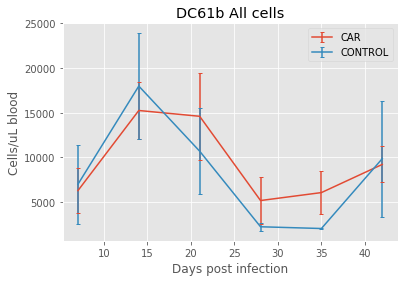

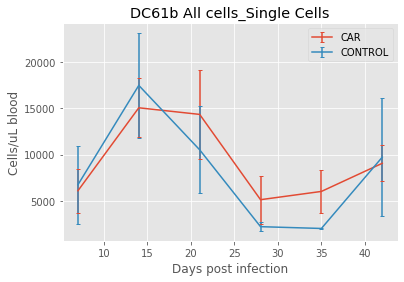

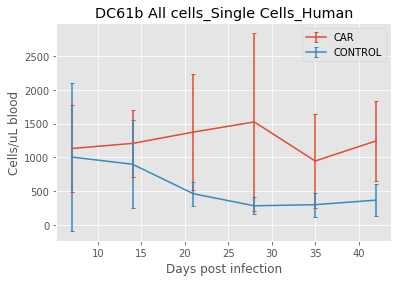

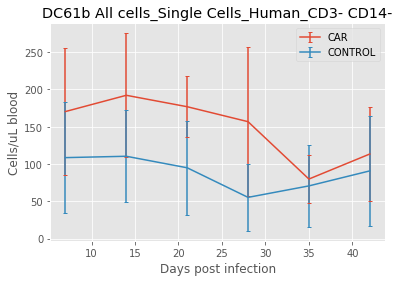

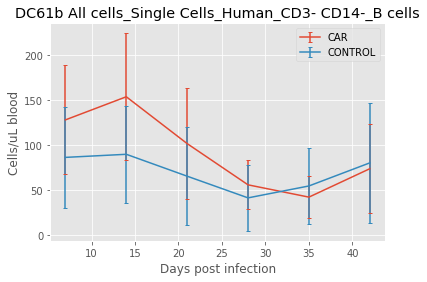

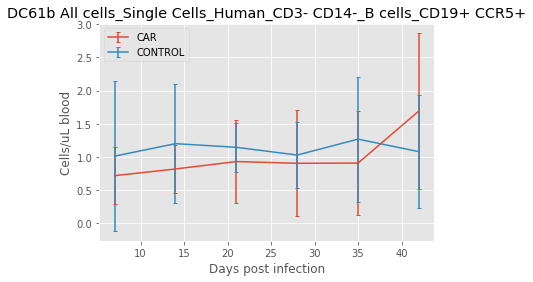

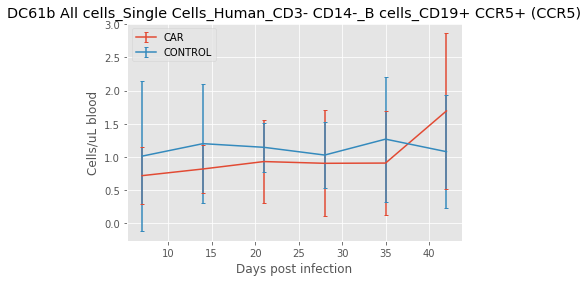

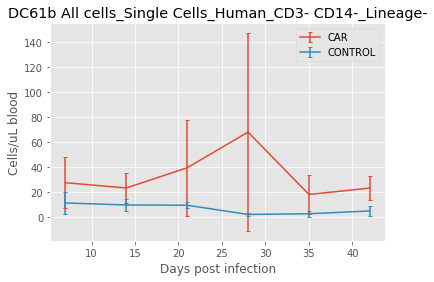

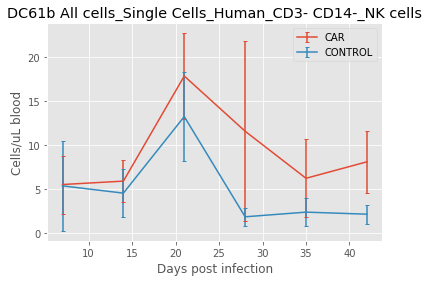

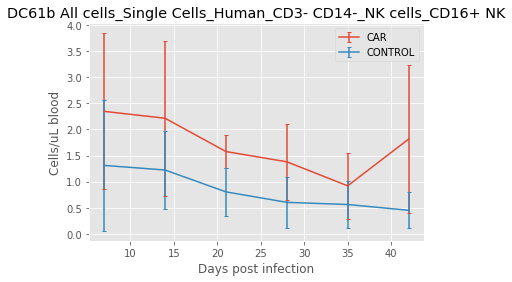

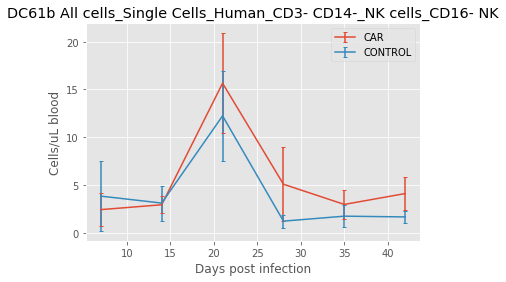

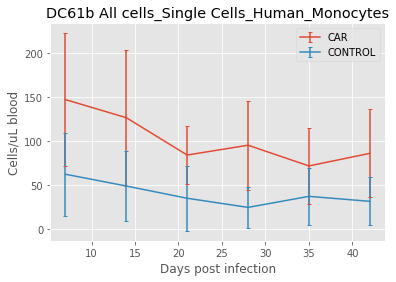

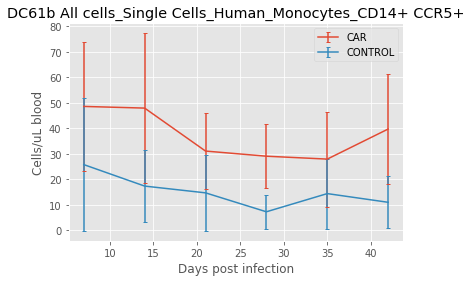

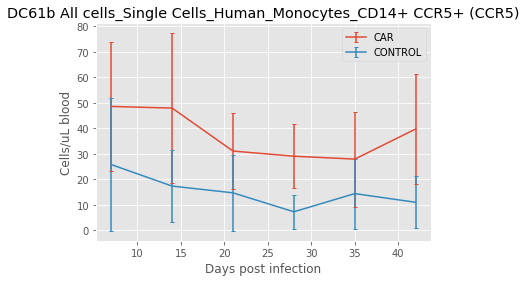

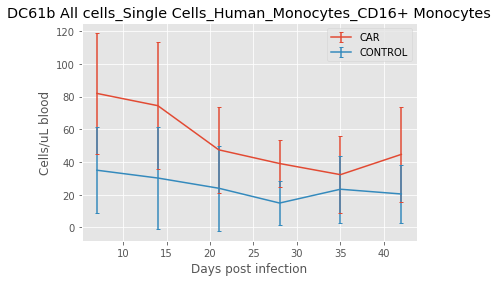

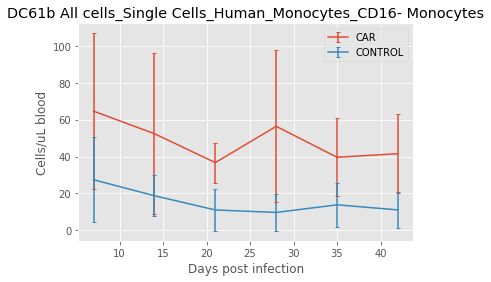

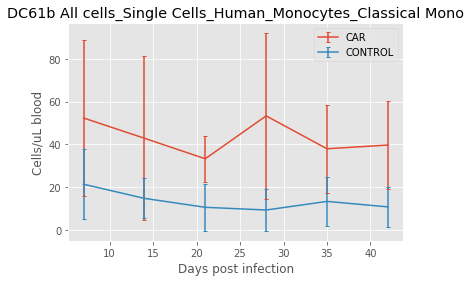

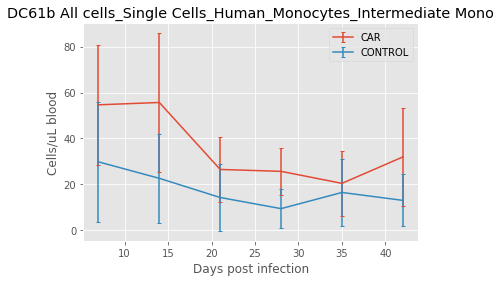

In [10]:
for gate_num in range (cols_to_skip,(row_list[0]-1)):
#for gate_num in range (cols_to_skip,20):
    partial_df = pd.DataFrame([])
    export_df = pd.DataFrame([])
    export_df_csv = pd.DataFrame([])
    df = pd.DataFrame([])
    significant = False
    for day in range(day_min,day_max):
        if path.exists(f'{day}_{study_name}.csv'):
            
            #read flowjo export csv file
            df = pd.read_csv(f'{day}_{study_name}.csv')
            
            #set column containing sample ID as index
            df.rename(columns={ df.columns[0]: 'Mouse ID' }, inplace = True)   
            df = df.set_index('Mouse ID')
            
            #clean and extract gate name to use for file name
            df.columns = [x.strip().replace('/','_') for x in df.columns]
            df.columns = [x.strip().replace(' | Count','') for x in df.columns]
            gate_name = df.columns[gate_num]
            
            #remove any rows that do not have study name in sample ID
            #CONSIDER REMOVING THIS AND HAVING USER CLEAN DATA THEMSELVES
            
            df = df.loc[df.index.str.contains(study_name)]
            
            #clean sample ID labels
            df.index = df.index.map(lambda x: str(x)[:-end_chars_del])
            df.index = df.index.map(lambda x: str(x)[-chars_to_keep:])
            
            #transpose
            df = df.transpose()
            
            #select column that contains 
            partial_df = df.iloc[gate_num]
            partial_df = partial_df.astype('float64')
            
            if calc_cells_ul == True:
                #calculate cells/uL blood
                countbeads_df = df.iloc[1]
                blood_df = df.iloc[0]
                countbeads_df = countbeads_df.astype('float64')
                blood_df = blood_df.astype('float64')
                partial_df = (partial_df/countbeads_df)*(countbeads_input/blood_df)
            
            #create dictionary specific to timepoint to run stats
            #key = group name, value = cells/uL
            
            while True:
                if statistics_selection == 1:
                    break
                timepoint_dictionary = {}
                for k in groups_dictionary.keys():
                    timepoint_df = partial_df.reindex(groups_dictionary[k])
                    timepoint_df = timepoint_df.tolist()
                    timepoint_dictionary.update({k:timepoint_df})

                #independent ttest
                if statistics_selection == 2:
                    throwaway, p_value = stats.ttest_ind(*(timepoint_dictionary.values()), nan_policy = 'omit')
                    p_val_name = 'p_val_ttest_ind'
                #one way anova
                if statistics_selection == 3:
                    throwaway, p_value = stats.f_oneway(*timepoint_dictionary.values())
                    p_val_name = 'p_val_f_oneway'
                #wilcoxon
                if statistics_selection == 4:
                    throwaway, p_value = stats.wilcoxon(*(timepoint_dictionary.values()))
                    p_val_name = 'p_val_wilcoxon'
                    
                p_value_series = pd.Series(p_value)
                p_value_series.index = [p_val_name]
                partial_df = pd.concat([p_value_series,partial_df])
                break

            #rename gate to day
            if show_gate_name_csv == True:
                partial_df_csv = partial_df.rename(f'{day}_{gate_name}')
            else:
                partial_df_csv = partial_df.rename(day)
            partial_df = partial_df.rename(day)
                
            #append to df that will be exported
            export_df = pd.concat([export_df,partial_df], axis =1)
            export_df_csv = pd.concat([export_df_csv,partial_df_csv], axis =1)
    
    #transpose and export dataframe to csv file
    export_df = export_df.transpose()
    
    export_df_dic.update({gate_name:export_df})
    #add a group_id column    
    if show_groups_csv == True and path.exists(f'groups_{study_name}.csv') == True:
        export_group_series = pd.Series([], dtype = 'object')
        for col in range(len(groups_df.columns)):
            group_name_series = [groups_df.columns[col]]
            group_series = groups_df.iloc[:,col]
            group_series = group_series.dropna()
            group_series = group_series.astype('int64')
            group_series = group_series.astype(str)
            group_name_series = group_name_series*len(group_series)
            partial_series = pd.Series(group_name_series)
            partial_series.index = group_series
            export_group_series = pd.concat([export_group_series, partial_series])
        export_group_series.name = 'Group'
        export_df_csv = pd.concat([export_group_series, export_df_csv], axis = 1)
    
    #transpose
    export_df_csv = export_df_csv.transpose()
    
    if statistics_selection == 1:
        export_df_csv.to_csv(f'{study_name}_{gate_name}.csv')
    
    #move p_value to first column
    if statistics_selection != 1:
        first_col = export_df_csv.pop(p_val_name)
        export_df_csv.insert(0, p_val_name,first_col)
    
    #Significant = True if any p-value for gate is < 0.05
        p_value_list = export_df_csv[p_val_name]
        p_value_list = p_value_list.tolist()
        if any (p < sig_p_value for p in p_value_list):
            significant = True
    
        if significant == True:
            export_df_csv.to_csv(f'{study_name}_{gate_name}_SIGNIFICANT.csv')
        else:
            export_df_csv.to_csv(f'{study_name}_{gate_name}.csv')
                             
    days_x = pd.Series(export_df.index.values.tolist())
    
    for k in groups_dictionary.keys():
        group_df = export_df.loc[:,groups_dictionary[k]]
        group_mean = group_df.mean(axis=1, skipna = True)
        if error_bar_choice == 1:
            group_error = group_df.std(axis=1, skipna = True)
        if error_bar_choice == 2:
            group_error = group_df.sem(axis=1, skipna = True)
        plt.errorbar(days_x, group_mean, yerr = group_error, capsize = 2, label = k)
    
    plt.legend()
    plt.title(study_name+' '+gate_name)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.tight_layout
    plt.style.use(plot_style_choice)
    if significant == True:
        plt.savefig((f'{study_name}_{gate_name}_SIGNIFICANT.png'))
    else:
        plt.savefig((f'{study_name}_{gate_name}.png'))
    plt.show()
    plt.close()

In [11]:
cell_pop_list = []
print('Enter cell populations to plot. Enter d when done')
while True:
    cell_pop_name = input()
    if cell_pop_name == 'd':
        break
    if cell_pop_name in export_df_dic.keys():
        cell_pop_list.append(cell_pop_name)
    else:
        print('Cell population not found, please try again with correct formatting')

print('Enter group to plot. Group must be designated in groups_xx.csv')
while True:
    group_name = input()
    if group_name.upper() in groups_dictionary.keys():
        break
    print('Group not in groups_xx.csv')
print('Please enter plot title name')
plot_title = input()

Enter cell populations to plot. Enter d when done
All cells_Single Cells_Human_Monocytes_Intermediate Mono
All cells_Single Cells_Human_Monocytes_Classical Mono
d
Enter group to plot. Group must be designated in groups_xx.csv
CAR
Please enter plot title name
blah


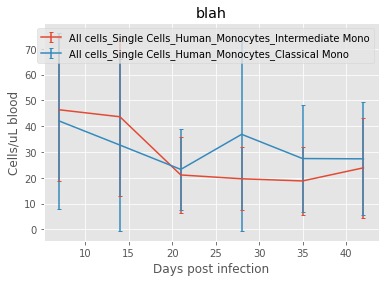

In [12]:
for cell_pop in cell_pop_list:
    cell_pop_df = export_df_dic[cell_pop]
    days_x = pd.Series(cell_pop_df.index.values.tolist())
    cell_pop_mean = cell_pop_df.mean(axis=1, skipna = True)
    cell_pop_std = cell_pop_df.std(axis=1, skipna = True)
    plt.errorbar(days_x, cell_pop_mean, yerr = cell_pop_std, capsize = 2, label = cell_pop)
    
plt.legend()
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
plt.title(plot_title)
plt.show()

In [ ]:
export_df_dic.keys()